## Observations and Insights 

In [105]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)

# Combine the data into a single dataset
df = pd.merge(mouse_metadata_df, study_results_df, how="left", on="Mouse ID")

# Display the data table for preview
df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [106]:
# Check the number of mice.
num_mice = len(df["Mouse ID"].unique())
num_mice

249

In [107]:
# Find any duplicate rows with the same Mouse IDs and Timepoints. 
dup_mice = df[df.duplicated(["Mouse ID", "Timepoint"], keep=False)]

# Check for number of different mice with duplicates
len(dup_mice["Mouse ID"].unique())
dup_mice

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [108]:
# Drop any duplicate rows
df = df.drop(df.loc[df["Mouse ID"]==dup_mice.iloc[1,0]].index)

In [109]:
# Recheck the number of mice
num_mice = len(df["Mouse ID"].unique())
num_mice

248

## Summary Statistics

In [110]:
# Generate a summary statistics table of mean, median, variance, 
# standard deviation, and SEM of the tumor volume for each regimen.
drug_gb = df.groupby("Drug Regimen")
tumor_stats = drug_gb.agg({"Tumor Volume (mm3)": ['mean', 'median', 'var', 'std', 'sem']})

tumor_stats.style.set_caption("Tumor Volume Statistics by Regimen")

## Bar and Pie Charts

***The rubric and the instructions contradict each other, so I did both ways--total number of mice per drug (first), and total number of datapoints per drug (second).***

Text(0, 0.5, 'Number of Mice')

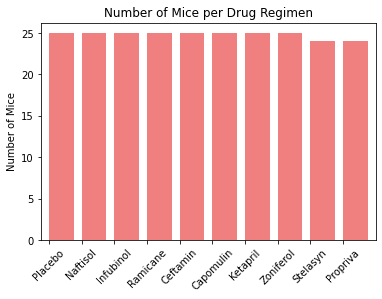

In [157]:
# Generate a bar plot showing the number of mice for each drug regimen using pandas.
trimmed_mice = df[["Mouse ID", "Drug Regimen"]].loc[~df['Mouse ID'].duplicated(keep="first")]

mouse_tick_locations = trimmed_mice["Drug Regimen"].value_counts(sort=True).index.tolist()

points_bar = trimmed_mice["Drug Regimen"].value_counts(sort=True).plot.bar(title="Number of Mice per Drug Regimen", 
                                                                  color="lightcoral", 
                                                                  width=0.75,
                                                                  align="edge",
                                                                  rot=45)
points_bar.set_ylabel("Number of Mice")

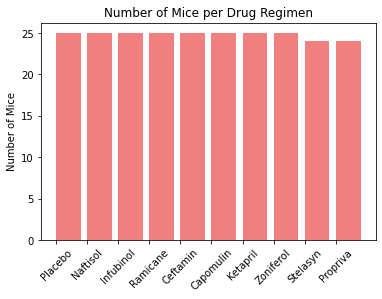

In [158]:
# Generate a bar plot showing the number of mice for each drug regimen using matplotlib.

plt.bar(mouse_tick_locations, trimmed_mice["Drug Regimen"].value_counts(sort=True),
        align="edge", 
        color="lightcoral")
plt.xticks(rotation=45)
plt.title("Number of Mice per Drug Regimen")
plt.ylabel("Number of Mice")
plt.show()

Capomulin    230
Ramicane     228
Ketapril     188
Naftisol     186
Zoniferol    182
Placebo      181
Stelasyn     181
Infubinol    178
Ceftamin     178
Propriva     148
Name: Drug Regimen, dtype: int64

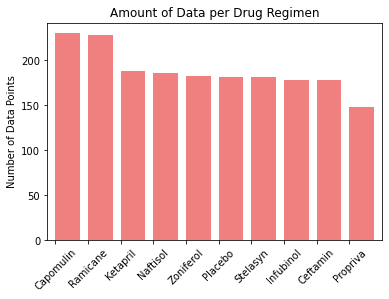

In [162]:
# Generate a bar plot showing the total number of datapoints for each drug regimen using pandas.

drug_tick_locations = df["Drug Regimen"].value_counts(sort=True).index.tolist()

points_bar = df["Drug Regimen"].value_counts().plot.bar(title="Amount of Data per Drug Regimen", 
                                                       color="lightcoral", 
                                                       width=0.75, 
                                                       align="edge",
                                                       rot=45)
points_bar.set_ylabel("Number of Data Points")

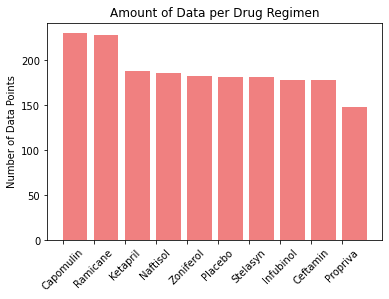

Capomulin    230
Ramicane     228
Ketapril     188
Naftisol     186
Zoniferol    182
Placebo      181
Stelasyn     181
Infubinol    178
Ceftamin     178
Propriva     148
Name: Drug Regimen, dtype: int64

In [163]:
# Generate a bar plot showing the total number of datapoints for each drug regimen using matplotlib.

plt.bar(drug_tick_locations, df["Drug Regimen"].value_counts(), 
        align="edge", 
        color="lightcoral")
plt.xticks(rotation=45)
plt.title("Amount of Data per Drug Regimen")
plt.ylabel("Number of Data Points")
plt.show()

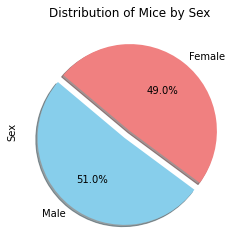

In [115]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
colors = ["skyblue", "lightcoral"]
df["Sex"].value_counts().plot.pie(title="Distribution of Mice by Sex", 
                                  colors=colors, explode=(0.1,0), 
                                  shadow=True, 
                                  autopct="%1.1f%%", 
                                  startangle=140)


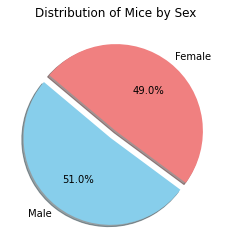

In [116]:
# Generate identical pie plot using pyplot
plt.pie(df["Sex"].value_counts(), 
        labels=df["Sex"].unique(), 
        colors=colors,
        explode = (0.1,0), 
        autopct="%1.1f%%", 
        shadow=True, 
        startangle=140)
plt.title("Distribution of Mice by Sex")
plt.show()

## Quartiles, Outliers and Boxplots

In [117]:
##### Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
mouse_gb = df.groupby("Mouse ID")
last_time = mouse_gb["Timepoint"].transform(max) == df["Timepoint"]

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
df["Final Tumor Volume"] = df[last_time]["Tumor Volume (mm3)"]

Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.

In [127]:
# Calculate quartiles, IQR, and identify potential outliers for each regimen.

fin_tumor_vol = {
    "Capomulin": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Capomulin") & df["Final Tumor Volume"]].tolist(),
    "Ramicane": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Ramicane") & df["Final Tumor Volume"]].tolist(),
    "Infubinol": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Infubinol") & df["Final Tumor Volume"]].tolist(),
    "Ceftamin": df["Final Tumor Volume"].loc[(df["Drug Regimen"] == "Ceftamin") & df["Final Tumor Volume"]].tolist()
}

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

for key in fin_tumor_vol.keys():
    lowerq = np.quantile(fin_tumor_vol[key], .25)
    upperq = np.quantile(fin_tumor_vol[key], .75)
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"The IQR for {key} is {round(iqr,4)}.\n \
    Values below {round(lower_bound,4)} could be outliers.\n \
    Values above {round(upper_bound,4)} could be outliers.")
    for val in fin_tumor_vol[key]:
        if (val > upper_bound)|(val < lower_bound):
            print(f"*** {round(val,2)} from the {key} regimen is a potential outlier. ***")

    print("--------------------------------------------------------")
    

The IQR for Capomulin is 7.7819.
     Values below 20.7046 could be outliers.
     Values above 51.832 could be outliers.
--------------------------------------------------------
The IQR for Ramicane is 9.0985.
     Values below 17.9127 could be outliers.
     Values above 54.3068 could be outliers.
--------------------------------------------------------
The IQR for Infubinol is 11.4771.
     Values below 36.8329 could be outliers.
     Values above 82.7414 could be outliers.
*** 36.32 from the Infubinol regimen is a potential outlier. ***
--------------------------------------------------------
The IQR for Ceftamin is 15.5778.
     Values below 25.3554 could be outliers.
     Values above 87.6665 could be outliers.
--------------------------------------------------------


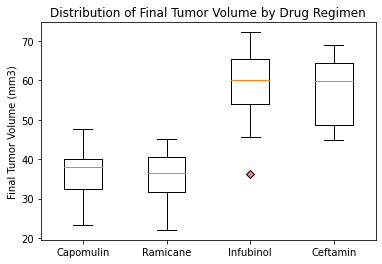

In [62]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
# There should be a single chart with four box plots inside it.
labels, data = fin_tumor_vol.keys(), fin_tumor_vol.values()

plt.boxplot(data, flierprops=dict(markerfacecolor='lightcoral', marker='D'))
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel("Final Tumor Volume (mm3)")
plt.title("Distribution of Final Tumor Volume by Drug Regimen")
plt.show()

## Line and Scatter Plots

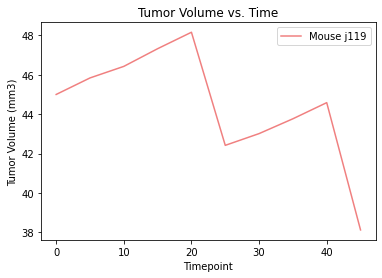

In [46]:
# Randomly choosing a mouse on the Capomulin regimen
rand_mouse = df["Mouse ID"].loc[df["Drug Regimen"]=="Capomulin"].sample().values

# Define x and y values
rand_mouse_time = df["Timepoint"].loc[(df["Drug Regimen"]=="Capomulin") & 
                                      (df["Mouse ID"]==rand_mouse[0])]
rand_mouse_vol = df["Tumor Volume (mm3)"].loc[(df["Drug Regimen"]=="Capomulin") & 
                                              (df["Mouse ID"]==rand_mouse[0])]

# Generate a line plot of tumor volume vs. time point for a single mouse 
# treated with Capomulin
plt.plot(rand_mouse_time, rand_mouse_vol, color="lightcoral")
plt.title("Tumor Volume vs. Time")
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume (mm3)")
plt.legend([f"Mouse {rand_mouse[0]}"], loc=0)

plt.show()

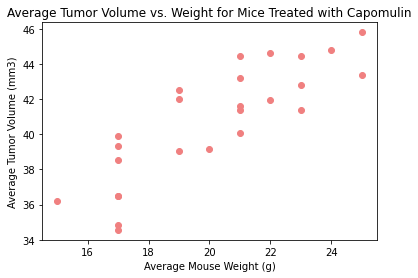

In [15]:
# Generate a scatter plot of average tumor volume vs. mouse weight 
# for all mice in the Capomulin regimen
mouse_weight = df["Weight (g)"].loc[df["Drug Regimen"]=="Capomulin"].groupby(df["Mouse ID"]).mean()
mouse_tumor = df["Tumor Volume (mm3)"].loc[df["Drug Regimen"]=="Capomulin"].groupby(df["Mouse ID"]).mean()

plt.scatter(mouse_weight, mouse_tumor, color="lightcoral")
plt.title("Average Tumor Volume vs. Weight for Mice Treated with Capomulin")
plt.xlabel("Average Mouse Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The data can be approximated with y = 0.95x + 21.55. 
The correlation coefficient r is 0.84. 
Rsquared is 0.71.


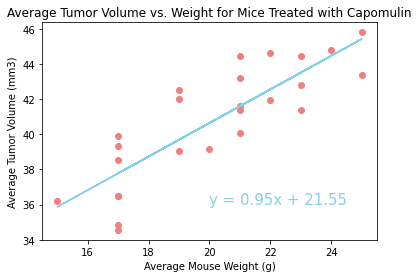

In [16]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
(slope, intercept, rvalue, pvalue, stderr) = linregress(mouse_weight, mouse_tumor)
line_eq = f"y = {round(slope,2)}x + {round(intercept,2)}"
regress_values = mouse_weight * slope + intercept
print(f"The data can be approximated with {line_eq}. \nThe correlation coefficient r is {round(rvalue,2)}. \nRsquared is {round(rvalue**2,2)}.")

plt.scatter(mouse_weight, mouse_tumor, color="lightcoral")
plt.plot(mouse_weight, regress_values, color="skyblue")
plt.annotate(line_eq, (20,36), fontsize=15, color="skyblue")
plt.title("Average Tumor Volume vs. Weight for Mice Treated with Capomulin")
plt.xlabel("Average Mouse Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.show()


# Observations and Insights

['l509']
